In [1]:
using DifferentialEquations, Plots, LaTeXStrings

# Capacitively Coupled Parallel RLC Circuit

Kirchoff's voltage law gives us, for each closed loop around the circuit

$$ V(t) = \frac{Q}{C_{CL}} + L \dot{I}_L $$

$$ V(t) = \frac{Q}{C_{CL}} + I_R $$

$$ V(t) = \frac{Q}{C_{CL}} + L \frac{Q_C}{C} $$

Relating these equations gives

$$ L\dot{I}_L = I_R R $$

$$ L\dot{I}_L = \frac{Q_C}{C} $$

Then using Kirchoff's current law, $I = I_C + I_R + I_L$, along with the fact that $I = \frac{dQ}{dt}$  and $ I_C = \frac{dQ_C}{dt}$, we get a second order differential equation for the current in the inductive element

$$ \ddot{I}_L = \frac{-1}{C_c + C}\left(\frac{1}{R} \dot{I}_L + \frac{1}{L} I_L\right) + \frac{\omega V_0 \cos(\omega t)}{L\left(1 + \frac{C}{C_c}\right)} $$

## RLC Model Parameters

In [2]:
const V₀ = 1.0
const Q = 1000.0
const C = 1.0
const Cc = 0.1
const L = 1.0;

parrallel resistance:

In [3]:
R = Q / sqrt(C / L)

1000.0

rosonance frequency:

In [4]:
ω₀ = 1 / sqrt(L * C)

1.0

## Problem Setup

In [5]:
function parallelRLC(ddI, dI, I, ω, t)
    @. ddI = -1 / (Cc + C) * (1 / R * dI + 1 / L * I) + ω * V₀ * cos(ω * t) / (L * (1 + C / Cc))
end;

problem parameters:

In [6]:
tspan = (0.0, 50.0)
dt = 0.001;

algorithm:

In [7]:
alg = VerletLeapfrog();

## Demo Solution

In [8]:
driving_frequency = π / 2;

In [9]:
prob = SecondOrderODEProblem(parallelRLC, [0.0], [0.0], tspan, driving_frequency);

In [10]:
sol = solve(prob, alg, dt=dt);

In [11]:
plot(sol.t, sol[2,:], label=L"I(t)", xlabel=L"t")
plot!(sol.t, sol[1,:], label=L"dI/dt")
plot!(sol.t, sin.(driving_frequency .* sol.t), label="driving voltage")

## Resonance Sweep

In [12]:
ωs = 0:0.01:π;

In [13]:
parallel_peaks = Vector{Float64}(undef, length(ωs))
for (i, ω) in enumerate(ωs)
    problem = SecondOrderODEProblem(parallelRLC, [0.0], [0.0], tspan, ω)
    solution = solve(problem, alg, dt=dt)
    parallel_peaks[i] = maximum(solution[2,:])
end

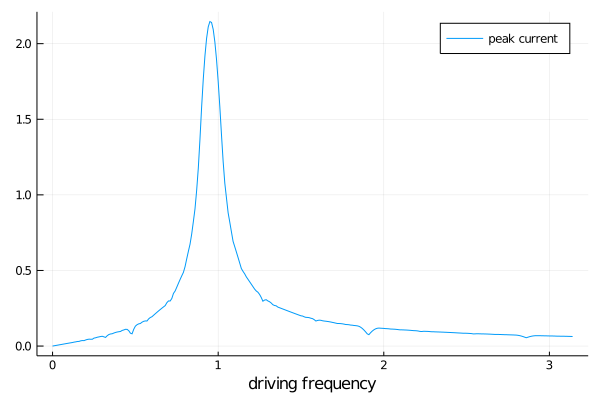

In [14]:
plot(ωs, parallel_peaks, label="peak current", xlabel="driving frequency")

## Series RLC Circuit


$$V(t) = L \dot{I} + I R + C^{-1} Q$$

Taking a derivative with the assumption inductance is time-independent and the current source is given by $V_0 \sin(\omega t)$ we get a second order differential equation for current.

$$\ddot{I} = -\frac{R}{L} \dot{I} - \frac{1}{CL} I + \frac{\omega V_0 \cos(\omega t)}{L}$$


In [15]:
series_R = sqrt(L / C) / Q

0.001

In [16]:
function seriesRLC(ddI, dI, I, ω, t)
    @. ddI = -series_R / L * dI - 1 / C / L * I + ω * V₀ * cos(ω * t) / L
end;

In [17]:
series_peaks = Vector{Float64}(undef, length(ωs))
for (i, ω) in enumerate(ωs)
    problem = SecondOrderODEProblem(seriesRLC, [0.0], [0.0], tspan, ω)
    solution = solve(problem, alg, dt=dt)
    series_peaks[i] = maximum(solution[2,:])
end

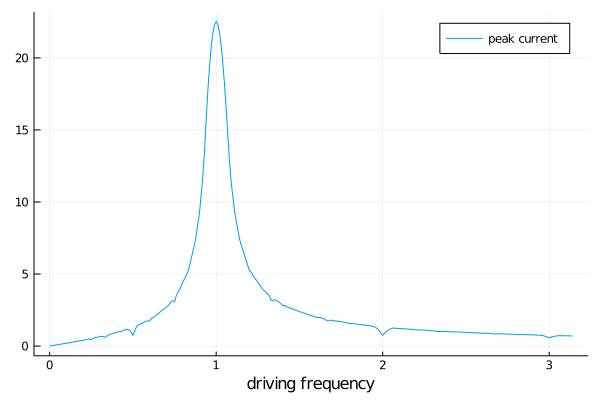

In [18]:
plot(ωs, series_peaks, label="peak current", xlabel="driving frequency")

# Qubit Circuit

By replacing the inductor in the RLC circuit with a Josephson Junction, we get a time-dependent inductance defined as

$$L_J (I_J(t)) = \frac{\Phi_0}{2\pi \sqrt{I_c^2- I_J^2(t)}}$$

Which gives us the following differential equation for the current, $I_J$, in the Josephson Junction

$$\ddot{I}_J = \frac{-1}{C_{CL} + C_{s + J}} \left(\frac{1}{R} \dot{I}_J + \frac{1}{L_J} I_J \right) - \frac{I_J}{I_c^2 - I_J^2} \dot{I}_J^2 + \frac{\omega V_0 \cos(\omega t)}{L_J\left(1 + \frac{C_{s + J}}{C_{CL}}\right)}   $$
          

## Parameters

In [19]:
const CCL = 0.1
const Cs = 39.9e-15
const CJ = 7.0e-15
const Cg = 5.0e-15
const CΣ = Cs + CJ + Cg
const Ic = 2.21e-8
const Rn = 14.0e-3
const Φ₀ = 2.06783383e-15
const qubitV₀ = 0.000001
const ħ = 1.0545718e-34;

In [20]:
qubit_Q = 1e6
qubit_R = qubit_Q / sqrt(100 / 1)

100000.0

## Problem Setup

In [21]:
function qubit(ddI::Vector{Complex{Float64}}, 
               dI::Vector{Complex{Float64}}, 
               I::Vector{Complex{Float64}}, 
               ω, 
               t)
    @. ddI = -1 / (CCL + Cs + CJ) * 
             (1 / qubit_R * dI + 1 / (Φ₀ / (2π * sqrt(Complex(Ic^2 - I^2)))) * I) - 
             I / (Ic^2 - I^2) * dI^2 + 
             ω * qubitV₀ * cos(ω * t) / 
             ((Φ₀ / (2π * sqrt(Complex(Ic^2 - I^2)))) * (1 + (Cs + CJ) / CCL))
end;

In [59]:
qubit_tspan = (0.0, 1e-3)
qubit_dt = 1e-5
qubit_ωs = 0:1e-5:1
qubit_peaks = Vector{Float64}(undef, length(qubit_ωs))
qubit_alg = VerletLeapfrog();

## Solutions

In [75]:
for (i, ω) in enumerate(qubit_ωs)
    problem = SecondOrderODEProblem(qubit, Complex.([0.0]), Complex.([0.0]), qubit_tspan, ω)
    solution = solve(problem, alg, dt=qubit_dt, reltol=1e-8, abstol=1e-8)
    qubit_peaks[i] = maximum(abs.(solution[2,:]))
end

┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/aaron/.julia/packages/DiffEqBase/T5smF/src/integrator_interface.jl:349
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/aaron/.julia/packages/DiffEqBase/T5smF/src/integrator_interface.jl:349
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/aaron/.julia/packages/DiffEqBase/T5smF/src/integrator_interface.jl:349
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/aaron/.julia/packages/DiffEqBase/T5smF/src/integrator_interface.jl:349
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/aaron/.julia/packages/DiffEqBase/T5smF/src/integrator_interface.jl:349
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/aaron/.julia/packages/DiffEqBase/T5smF/src/integrator_interface.jl:349
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/aaron/.julia/packages/DiffEqBase/T5smF/src/integrator_interface.jl:349
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home

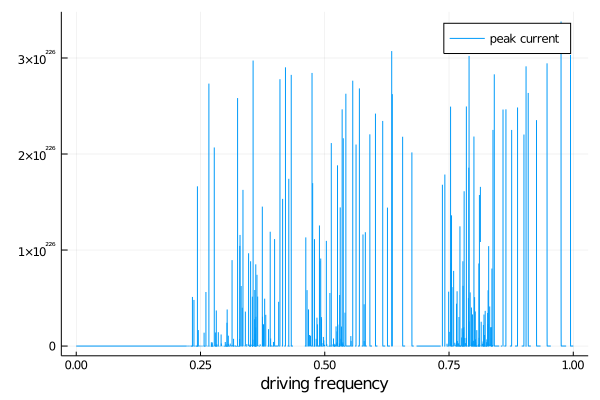

In [76]:
plot(qubit_ωs, qubit_peaks, label="peak current", xlabel="driving frequency")

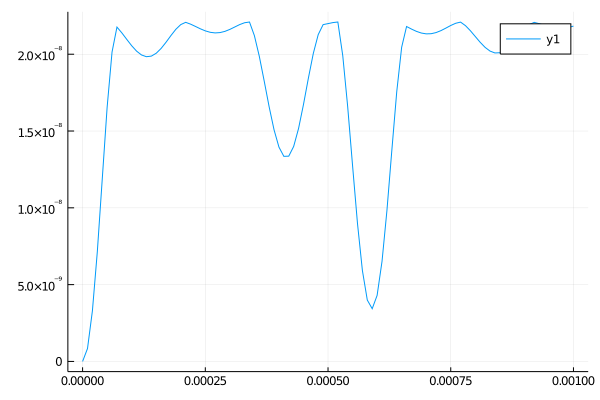

In [65]:
qubit_problem = SecondOrderODEProblem(qubit, [0.0 + 0.0im], [0.0 + 0.0im], qubit_tspan, 0.25)
qubit_sol = solve(qubit_problem, qubit_alg, dt=qubit_dt)
plot(qubit_sol.t, abs.(qubit_sol[2,:]))

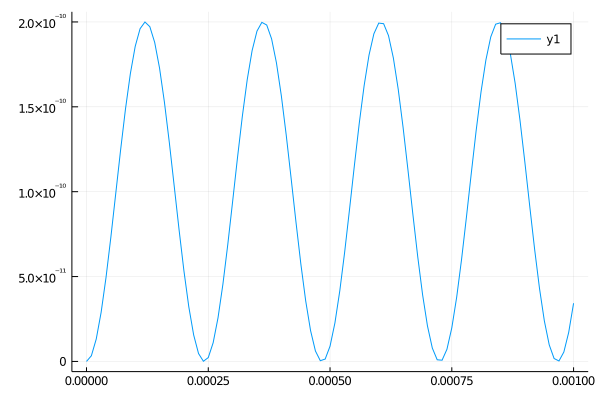

In [74]:
qubit_problem = SecondOrderODEProblem(qubit, [0.0 + 0.0im], [0.0 + 0.0im], qubit_tspan, 0.001)
qubit_sol = solve(qubit_problem, qubit_alg, dt=qubit_dt)
plot(qubit_sol.t, abs.(qubit_sol[2,:]))